# Data preprocessing

## Imports

In [14]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from collections import defaultdict

## Data analisys

assign paths for the folders we need

for convenience, i will create a two-dimensional list so I don't have to write a lot of paths

In [15]:
def get_path(part: str = 'test', data: str = 'images') -> str:
    '''func for easy gettin` folder path'''
    return fr'D:\Helper\MLBazyak\homework\06_01\price_detection\data\{part}\{data}'

# data_parts
dp = [
      ['test', 'images', 'labels', 'labels_rw'],
      ['train', 'images', 'labels', 'labels_rw'],
      ['valid', 'images', 'labels', 'labels_rw']
      ]

In [16]:
# testin` our path`s func
print(get_path())
print(get_path(dp[0][0], dp[0][1]))
# noice

D:\Helper\MLBazyak\homework\06_01\price_detection\data\test\images
D:\Helper\MLBazyak\homework\06_01\price_detection\data\test\images


observe the distribution of classes in the folders

In [17]:
colors = ['#0f1d87', '#0a64f7', '#6abee6']         # set colors pallete that i want

fig, axes = plt.subplots(1,3, figsize=(15,5))      # assign graph
fig.suptitle('Class distribution in folders')

for i in range(3):                                 # going through all datasets 
    label_dir = get_path(dp[i][0], dp[1][2])
    class_stats = defaultdict(int)
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                class_stats[class_id] += 1

    print(f'Class statistics in the folder {dp[i][0]}:')      # printing classes statistic in folder
    for class_id, count in class_stats.items():
        print(f'Class {class_id}: {count} objects')
    print('-----------------------------------------')

    axes[i].bar(class_stats.keys(), class_stats.values(), color=colors[i])  # add a graph part
    axes[i].set_title(f'Folder {dp[i][0]}')
    axes[i].set_xlabel('Class ID')
    axes[i].set_ylabel('Number of input')
    axes[i].set_xticks(list(class_stats.keys()))

plt.tight_layout()
plt.show()

Class statistics in the folder test:
Class 0: 142 objects
Class 2: 142 objects
Class 1: 45 objects
Class 3: 53 objects
-----------------------------------------
Class statistics in the folder train:
Class 0: 1007 objects
Class 2: 1006 objects
Class 1: 281 objects
Class 3: 359 objects
-----------------------------------------
Class statistics in the folder valid:
Class 0: 290 objects
Class 2: 290 objects
Class 1: 82 objects
Class 3: 106 objects
-----------------------------------------


<Figure size 1500x500 with 3 Axes>

**after checking classes in YAT, i can say what:**

- 0 - product name
- 1 - price without stock     *<-- i need to find this on photo*
- 2 - up-to-date product price
- 3 - stock availability/type

*so i do not need to reshaping classes, and can work with base dataset (I think so)*

In [20]:
start_lbl = ['labels_test', 'labels_train', 'labels_valid']

for i in range(3):
    label_dir = fr'D:\Helper\MLBazyak\homework\06_01\price_detection\data\start_labels\{start_lbl[i]}'
    label_rw_dir = get_path(dp[i][0], dp[1][2])
    processed = 0
    for filename in os.listdir(label_dir):
        filepath = os.path.join(label_dir, filename)
        new_filepath = os.path.join(label_rw_dir, filename)

        with open(filepath, 'r') as f:
            lines = f.readlines()

        filtered_lines = []
        for line in lines:
            parts = line.strip().split()
            if parts and parts[0] == '2':
                parts[0] = '0'
                updated_line = ' '.join(parts) + '\n'
                filtered_lines.append(updated_line)
        
        with open(new_filepath, 'w') as f:
            f.writelines(filtered_lines)
        
        processed+=1
    
    print(f'Processing complete for {start_lbl[i]}.')
    print(f'Updated markups are saved in the {label_rw_dir} folder.')
    print(f'Processed files: {processed}')
    print('-----------------------------------------')


Processing complete for labels_test.
Updated markups are saved in the D:\Helper\MLBazyak\homework\06_01\price_detection\data\test\labels folder.
Processed files: 131
-----------------------------------------
Processing complete for labels_train.
Updated markups are saved in the D:\Helper\MLBazyak\homework\06_01\price_detection\data\train\labels folder.
Processed files: 914
-----------------------------------------
Processing complete for labels_valid.
Updated markups are saved in the D:\Helper\MLBazyak\homework\06_01\price_detection\data\valid\labels folder.
Processed files: 261
-----------------------------------------


# Model architecture

## Imports

`I think for recognizion model I will use YOLO (You Only Look Once), and as OCR model I will use EasyOCR`

 *(mb will test tesseract, but i do not like him)*

In [29]:
from ultralytics import YOLO
import easyocr
from PIL import Image
from re import findall

print('EasyOCR version:', easyocr.__version__)

EasyOCR version: 1.7.2


*test YOLO model*

In [21]:
model = YOLO('yolov8n.pt')

In [ ]:
results_test = model.train(
    data = r'D:\Helper\MLBazyak\homework\06_01\06_01_hw\data.yaml',
    epochs=3,
    imgsz=640,
    batch=8,
    cos_lr=True,
    lr0=0.01,
    name='test_ptice_detection'
)

Ultralytics 8.3.58  Python-3.11.9 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:\Helper\MLBazyak\homework\06_01\price_detection\data.yaml, epochs=3, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=test_ptice_detection2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False,

train: Scanning D:\Helper\MLBazyak\homework\06_01\price_detection\data\train\labels... 914 images, 3 backgrounds, 0 corrupt: 100%|██████████| 914/914 [00:02<00:00, 326.93it/s]

train: New cache created: D:\Helper\MLBazyak\homework\06_01\price_detection\data\train\labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning D:\Helper\MLBazyak\homework\06_01\price_detection\data\valid\labels... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<00:00, 336.95it/s]

val: New cache created: D:\Helper\MLBazyak\homework\06_01\price_detection\data\valid\labels.cache


Plotting labels to runs\detect\test_ptice_detection2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\test_ptice_detection2
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.801      2.934      1.576          5        640: 100%|██████████| 115/115 [08:42<00:00,  4.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

                   all        261        290      0.844      0.862       0.93      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3         0G      1.446      1.587       1.28          2        640: 100%|██████████| 115/115 [09:47<00:00,  5.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

                   all        261        290      0.887      0.969      0.966       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3         0G      1.369      1.325      1.241          2        640: 100%|██████████| 115/115 [08:53<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

                   all        261        290      0.946      0.971      0.983      0.604



3 epochs completed in 0.494 hours.
Optimizer stripped from runs\detect\test_ptice_detection2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\test_ptice_detection2\weights\best.pt, 6.2MB

Validating runs\detect\test_ptice_detection2\weights\best.pt...
Ultralytics 8.3.58  Python-3.11.9 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]


                   all        261        290      0.946       0.97      0.983      0.604
              name_tag        261        290      0.946       0.97      0.983      0.604
Speed: 2.5ms preprocess, 122.6ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs\detect\test_ptice_detection2


In [31]:
result_test = model(r'D:\Helper\MLBazyak\homework\06_01\price_detection\data\test\images\original_five_33_v3_jpg.rf.9e8bde5a93c18446991a3e0f37ef0c76.jpg')

for result in result_test:
    img = result.plot()  
    img = Image.fromarray(img)  
    img.show()           


image 1/1 D:\Helper\MLBazyak\homework\06_01\price_detection\data\test\images\original_five_33_v3_jpg.rf.9e8bde5a93c18446991a3e0f37ef0c76.jpg: 480x640 1 name_tag, 121.7ms
Speed: 1.8ms preprocess, 121.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


**For 3 epochs, quite a decent result:**

~~i accidently use wrong .yaml file, but it still cook~~

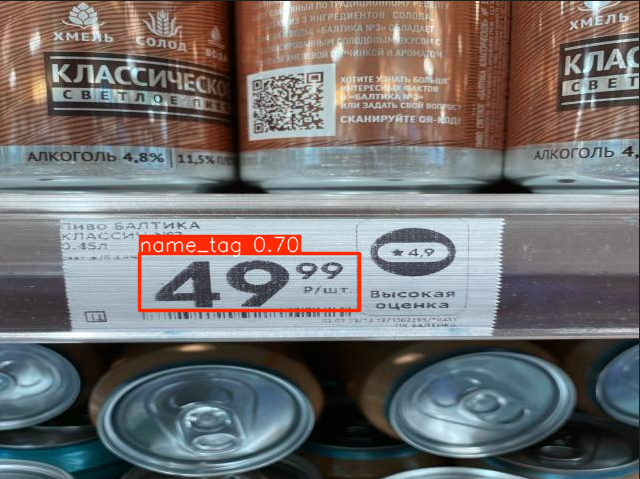

# Model learning

In [32]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:02<00:00, 9.41MB/s]


In [ ]:
results = model.train(
    data = r'D:\Helper\MLBazyak\homework\06_01\06_01_hw\data.yaml',
    epochs=3,
    imgsz=640,
    batch=8,
    cos_lr=True,
    lr0=0.01,
    name='price_detection')

In [ ]:
result = model(r'D:\Helper\MLBazyak\homework\06_01\price_detection\data\test\images\original_five_33_v3_jpg.rf.9e8bde5a93c18446991a3e0f37ef0c76.jpg')

for result in result_test:
    img = result.plot()  
    img = Image.fromarray(img)  
    img.show()  